# [English] Using machine learning to predict gold mining stock prices
> The analysis of gold prices and shares of gold mining companies using machine analysis methods

- toc:true- branch: master
- badges: true
- comments: true
- author: Zmey56
- categories: [english, machine learning, algotrading]

As a basis, I took a notebook published on [colab](https://colab.research.google.com/github/pythonbravo/oil_price/blob/master/A_Tour_of_the_Oil_Industry.ipynb) for oil. This notebook examines the analysis of gold prices and shares of gold mining companies using machine analysis methods: linear regression, cluster analysis, and random forest. I immediately warn you that this post does not attempt to show the current situation and predict the future direction. Just like the author for oil, this article does not aim to raise or refute the possibilities of machine learning for analyzing stock prices or other tools. I upgraded the code for gold research in order to encourage those who are interested in further reflection and listen to constructive criticism in their address.

In [6]:
pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 5.5MB 6.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=2b1a24b9e8937bf5603faead14841f6f3e045d79bd13bf0e76bc189db75a8640
  Stored in directory: /tmp/pip-ephem-wheel-cache-5al_gsvn/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [11]:
#Loading libraries
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

## 1. Loading data

For the price of gold, take the value of the exchange-traded investment Fund SPDR Gold Trust, whose shares are 100% backed by precious metal. The quotes will be compared with the prices of gold mining companies ' shares:
* Newmont Goldcorp (NMM)
* Barrick Gold (GOLD)
* AngloGold Ashanti (AU)
* Kinross Gold (KGC)
* Newcrest Mining (ENC)
* Polyus (PLZL)
* Polymetal (POLY)
* Seligdar (SELG)

In [49]:
gold = pd.DataFrame(yf.download("GLD", start="2010-01-01", end="2019-12-31")['Adj Close'])

[*********************100%***********************]  1 of 1 completed


In [50]:
gold = gold.reset_index()
gold.columns = ["Date","gold_price"]
gold['Date'] = pd.to_datetime(gold['Date'])
gold.head()

,Date,gold_price
0,2010-01-04,109.800003
1,2010-01-05,109.699997
2,2010-01-06,111.510002
3,2010-01-07,110.820000
4,2010-01-08,111.370003


It is necessary to move the price of gold, as we will be interested in how yesterday's price affected today's stock price.

In [51]:
gold["gold_price"] = gold["gold_price"].shift(1)

In [52]:
shares=["NMM.SG","GOLD","AU","KGC","NCM.AX","PLZL.ME","POLY.ME","SELG.ME"]
data= yf.download(shares, start="2010-01-01", end="2019-12-31")['Adj Close']

[*********************100%***********************]  8 of 8 completed


In [53]:
data = data.reset_index()
data.head()

,Date,AU,GOLD,KGC,NCM.AX,NMM.SG,PLZL.ME,POLY.ME,SELG.ME
0,2010-01-04,39.698944,34.561649,18.105721,33.237167,26.924570,NaN,NaN,NaN
1,2010-01-05,40.320408,34.989510,18.594805,33.901924,27.116940,NaN,NaN,NaN
2,2010-01-06,41.601028,35.733963,19.256504,33.901924,27.289278,NaN,NaN,NaN
3,2010-01-07,41.130215,35.229092,19.352404,34.298923,NaN,NaN,NaN,NaN
4,2010-01-08,41.601028,35.451572,19.601744,33.421829,27.702093,NaN,NaN,NaN


In [54]:
data['Date'] = pd.to_datetime(data['Date'])

In [55]:
#creating an array that will store all the data
all_data=pd.DataFrame()

In [56]:
#creating an array with quotes
for index in range(len(shares)):
    stock=pd.DataFrame()
    # transform the data
    stock=data.loc[:, ("Date",shares[index])]
    stock["Date"]=stock["Date"].astype('datetime64[ns]')
    stock.columns=["Date","share_price"]
    test=pd.DataFrame(gold) 
    output=stock.merge(test,on="Date",how="left") #combining two data sets
    stock["gold_price"]=output["gold_price"]
    stock['share_price']=pd.to_numeric(stock['share_price'], errors='coerce').dropna(0)
    stock['gold_price']=pd.to_numeric(stock['gold_price'], errors='coerce').dropna(0)
    stock["year"]=pd.to_datetime(stock["Date"]).dt.year #Create a column with years for subsequent filtering
    stock["name"]=shares[index]
    stock = stock.dropna() #delete all NAN lines
    #creating a column with a scaled share price
    scaler=MinMaxScaler()
    stock["share_price_scaled"]=scaler.fit_transform(stock["share_price"].to_frame())
    #add data to the main dataframe
    all_data=all_data.append(stock) #add the data

In [57]:
#leave data only from 2015 to 2019
all_data_15 = all_data[(all_data['year']>2014)&(all_data['year']<2020)]
all_data_15.head()

,Date,share_price,gold_price,year,name,share_price_scaled
1301,2015-01-02,14.269927,113.580002,2015,NMM.SG,0.052072
1302,2015-01-05,14.845476,114.080002,2015,NMM.SG,0.071190
1303,2015-01-06,15.601913,115.800003,2015,NMM.SG,0.096317
1304,2015-01-07,15.645762,117.120003,2015,NMM.SG,0.097773
1305,2015-01-08,15.517859,116.430000,2015,NMM.SG,0.093525


## 2. Data analysis

It is best to start analyzing data by presenting it visually, which will help you understand it better.

### 2.1 Chart of gold price changes

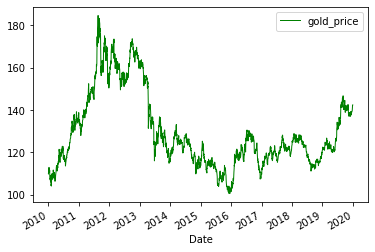

In [58]:
gold[['Date','gold_price']].set_index('Date').plot(color="green", linewidth=1.0)
plt.show()

### 2.2. Plotting the pairplot chart for the price of Polyus and Barrick Gold shares over the past five years

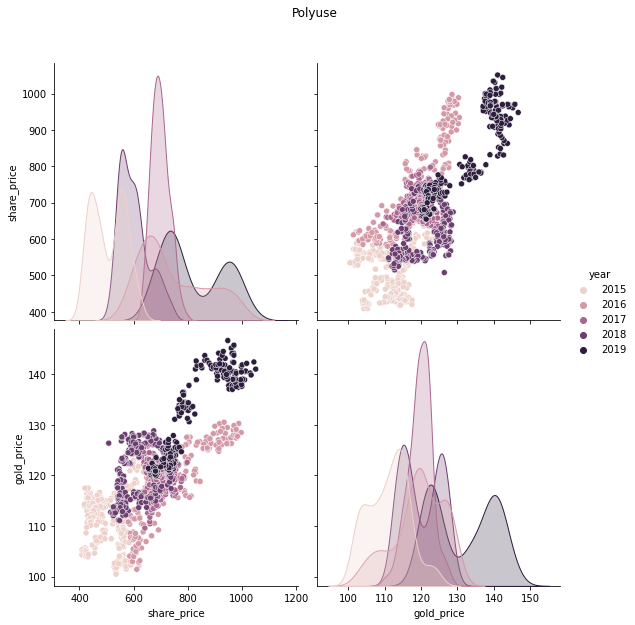

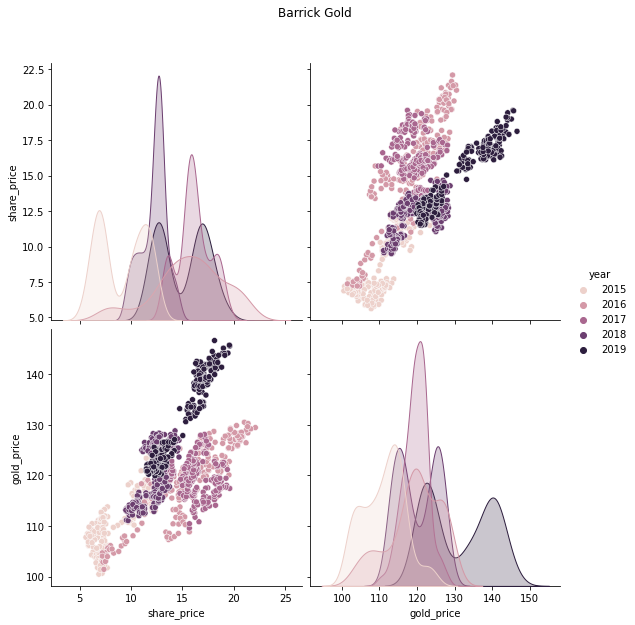

In [59]:
palette=sns.cubehelix_palette(18, start=2, rot=0, dark=0, light=.95, reverse=False)
g = sns.pairplot(all_data[(all_data['name']=="POLY.ME")&(all_data['year']>2014)&(all_data['year']<2020)].\
             drop(["share_price_scaled"],axis=1), hue="year",height=4)
g.fig.suptitle("Polyuse", y=1.08)

palette=sns.cubehelix_palette(18, start=2, rot=0, dark=0, light=.95, reverse=False)
f = sns.pairplot(all_data[(all_data['name']=="GOLD")&(all_data['year']>2014)&(all_data['year']<2020)].\
             drop(["share_price_scaled"],axis=1), hue="year",height=4)
f.fig.suptitle('Barrick Gold', y=1.08)

plt.show()

A paired graph allows you to see the distribution of data by showing the paired relationships in the data set and the univariate distribution of data for each variable. You can also use the palette to see how this data changed in different years.

The chart is particularly interesting for 2016 and 2019, as it looks like the price of the Pole stock, Barrick Gold and the price of gold are lined up along the same line. We can also conclude from the distribution charts that the price of gold and stocks moved gradually towards higher values.

### 2.3 Violinplot for the gold price

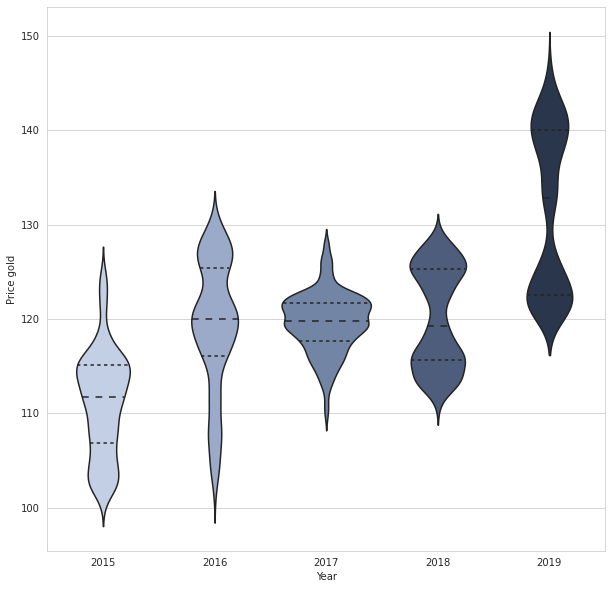

In [60]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
palette=sns.cubehelix_palette(5, start=2.8, rot=0, dark=0.2, light=0.8, reverse=False)

sns.violinplot(x="year", y="gold_price", data=all_data_15[["gold_price","year"]],
               inner="quart", palette=palette, trim=True)
plt.xlabel("Year")
plt.ylabel("Price gold")

plt.show()

### 2.4 Violinplot for multiple shares

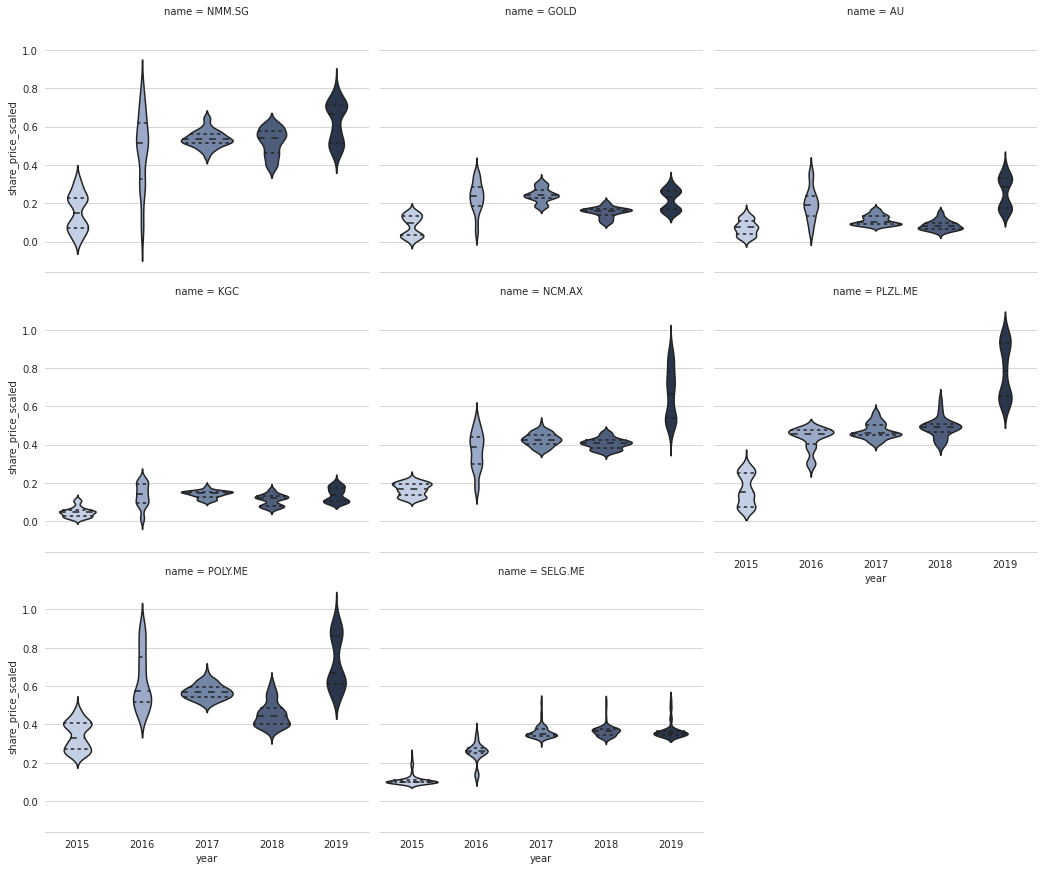

In [61]:
sns.catplot(x="year", y="share_price_scaled", col='name', col_wrap=3,kind="violin",
               split=True, data=all_data_15,inner="quart", palette=palette, trim=True, height=4, aspect=1.2)
sns.despine(left=True)

A large fluctuation in gold prices was noted according to the charts in 2016 and 2019. As you can see from the graphs in the following figure, some companies such as Newmont Mining, Barrick Gold, AngloGold Ashanti, Newcrest Mining and Polymetal were also affected. It should also be noted that all prices are marked in the range from 0 to 1 and this may lead to inaccuracies in the interpretation.

Next, we will build distribution charts for one Russian company - Polymetal and one foreign company - Barrick Gold

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


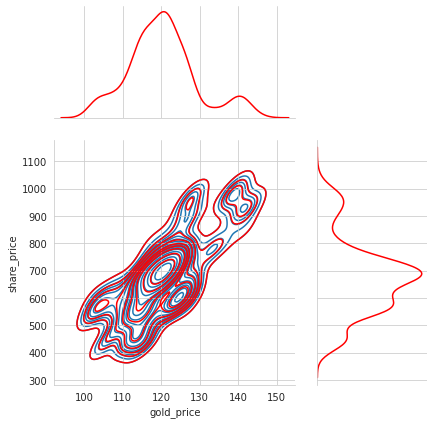

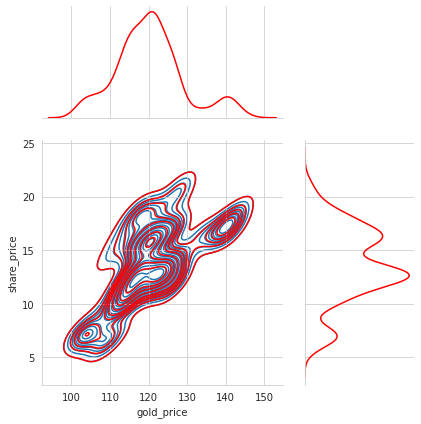

In [62]:
sns.jointplot("gold_price", "share_price",data=all_data_15[all_data_15['name']=="POLY.ME"],kind="kde",
              height=6,ratio=2,color="red").plot_joint(sns.kdeplot, zorder=0, n_levels=20)

sns.jointplot("gold_price", "share_price",data=all_data_15[all_data_15['name']=="GOLD"],kind="kde",
              height=6,ratio=2,color="red").plot_joint(sns.kdeplot, zorder=0, n_levels=20)
plt.show()

It is necessary to pay attention to the distribution of the share price for the two companies and it will become clear that the shape of the density graph is the same for them.

### 2.5 Charts of the dependence of the share price of various companies on the price of gold

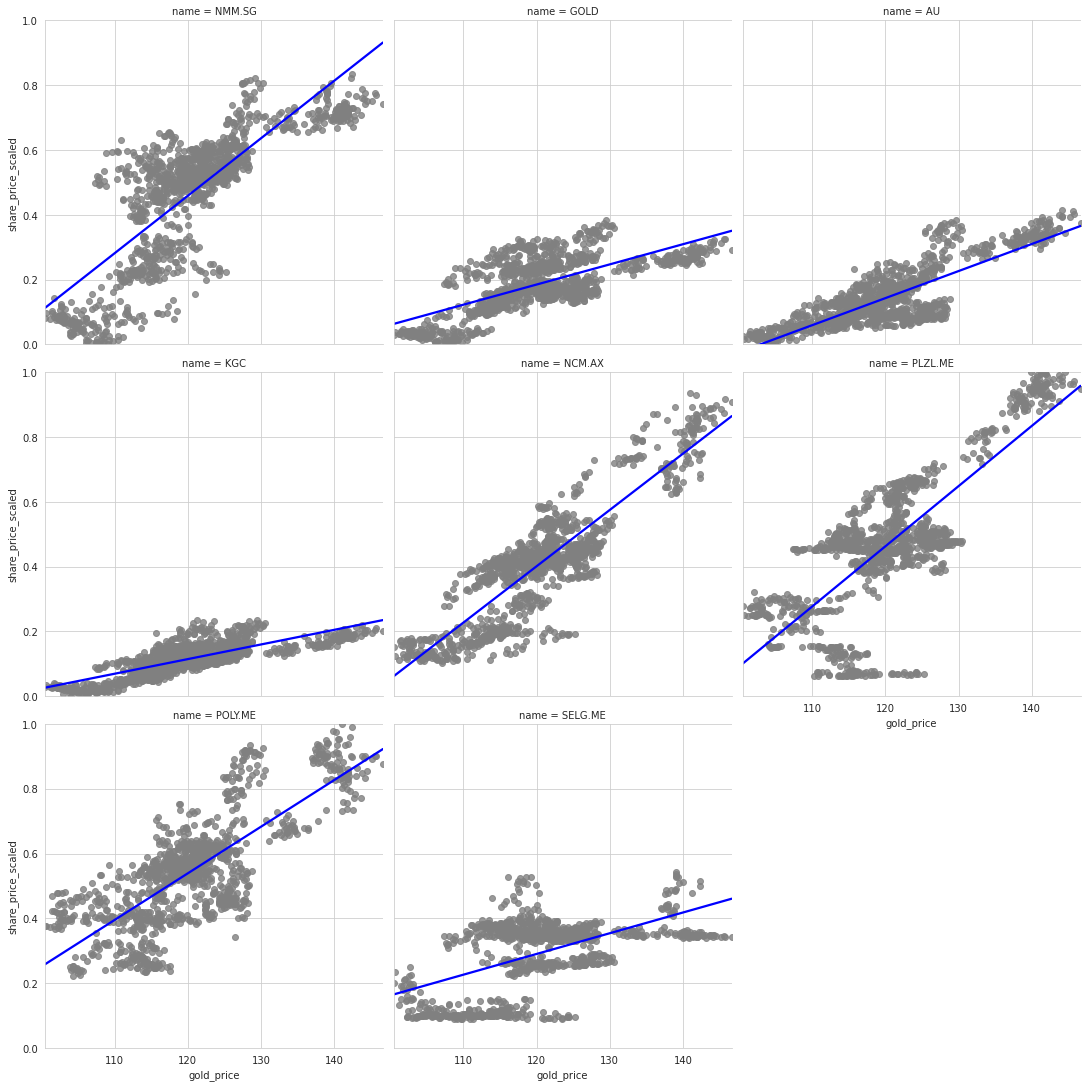

In [63]:
sns.lmplot(x="gold_price", y="share_price_scaled", col="name",ci=None, col_wrap=3, 
           data=all_data_15, order=1,line_kws={'color': 'blue'},scatter_kws={'color': 'grey'}).set(ylim=(0, 1))

plt.show()

In fact, you won't be able to see much on these charts, although some stocks seem to have a relationship.

The next step is to try to color the charts depending on the years.

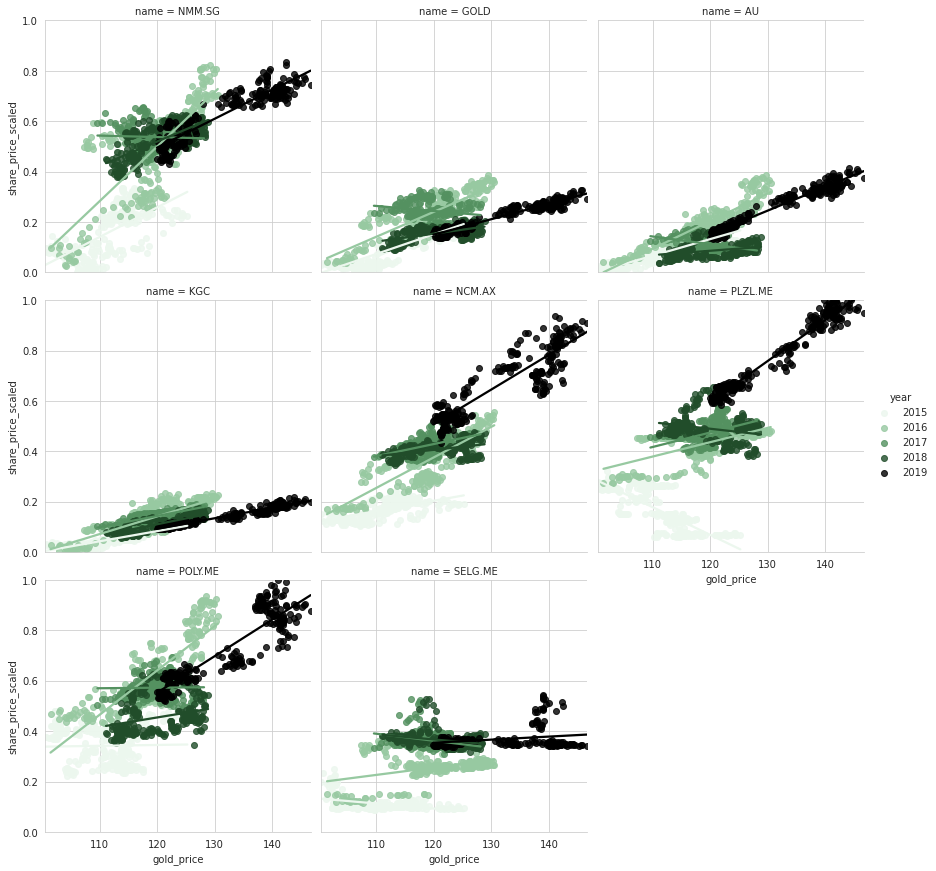

In [64]:
palette=sns.cubehelix_palette(5, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.lmplot(x="gold_price", y="share_price_scaled",hue="year", col="name",ci=None, 
           col_wrap=3, data=all_data_15, order=1,palette=palette,height=4).set(ylim=(0, 1))

plt.show()

Here the picture is a little better in the sense that some companies have a data cloud stretching along a straight line in some years, which may indicate the existence of a dependency.

## 3 Machine learning and prediction

I will give a definition for machine learning from Wikipedia: Machine learning is a class of artificial intelligence methods that are characterized not by direct problem solving, but by learning in the process of applying solutions to many similar problems. To build such methods, we use mathematical statistics, numerical methods, optimization methods, probability theory, graph theory, and various techniques for working with data in digital form.

Usually, machine learning algorithms can be classified into the following categories: learning with a teacher and learning without a teacher. Here is their definition from one of the sites:

Supervised learning is one of the sections of machine learning dedicated to solving the following problem. There is a set of objects (situations) and the set of possible answers (responses, reactions). There is some relationship between responses and objects, but it is unknown. Only a finite set of use cases is known — the "object, response" pairs, called the training sample. Based on this data, you need to restore the dependency, that is, build an algorithm that can give a fairly accurate answer for any object. To measure the accuracy of responses, a quality functional is introduced in a certain way. see the Links)

Unsupervised learning is one of the sections of machine learning. Studies a wide class of data processing problems in which only descriptions of a set of objects (training sample) are known, and it is required to detect internal relationships, dependencies, and patterns that exist between objects. Learning without a teacher is often contrasted with learning with a teacher, when each training object is given a "correct answer", and you need to find the relationship between the objects and the answers. see links)

The following machine learning methods will be discussed later:

* Cluster analysis
* Linear regression
* Random forest

Using these algorithms, you can evaluate overvalued or undervalued stocks relative to the price of gold and possible movement on the next day. I remind you that you must be very careful and use the conclusions from this post at your own risk. I also remind you that my main goal is to show the potential of machine learning for stock valuation.

### 3.1. Cluster analysis for Barrick Gold stock

Clustering is the task of dividing a set of objects into groups called clusters. Each group should contain "similar" objects, and objects from different groups should be as different as possible.

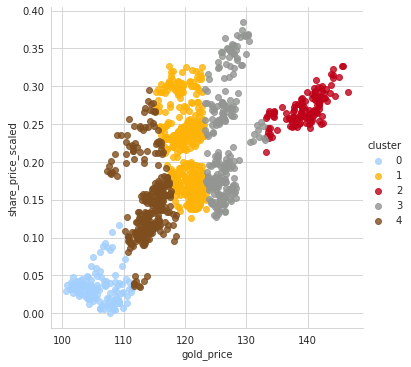

In [65]:
from sklearn.cluster import KMeans

poly=all_data_15[all_data_15['name']=="GOLD"]
# We need to scale also gold price, so clustering is not influenced by the relative size of one axis.
poly=pd.DataFrame(poly)
poly['gold_price_scaled'] = scaler.fit_transform(poly["gold_price"].to_frame())
poly["cluster"] = KMeans(n_clusters=5, random_state=1).fit_predict(poly[["share_price_scaled","gold_price_scaled"]])

# The 954 most common RGB monitor colors https://xkcd.com/color/rgb/
colors = ["baby blue", "amber", "scarlet", "grey","milk chocolate", "windows blue"]
palette=sns.xkcd_palette(colors)

sns.lmplot(x="gold_price", y="share_price_scaled",ci=None,palette=palette, hue="cluster",fit_reg=0 ,data=poly)

plt.show()

Cluster analysis is used in a large number of machine learning tasks. But I have given it only for informational purposes, since in this form it does not bring much benefit to our analysis.

### 3.2. Linear regression between Barrick Gold shares and the gold price

Next, we will build a regular linear regression using training with a teacher. The goal is to estimate the forecast of data for the last 100 days of 2019 based on data from 2018/2019 (excluding estimated ones). Training data is the data used to build the model, and test data is the data that we will try to predict.

NMM.SG
Coefficients:  0.6629423053739908
[[1.       0.790953]
 [0.790953 1.      ]]
Mean Absolute Error: 6.063058573972694
Mean Squared Error: 39.21188296210148
Root Mean Squared Error: 6.261939233344689


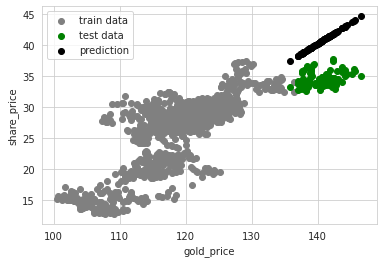

GOLD
Coefficients:  0.3355465472461071
[[1.         0.67139243]
 [0.67139243 1.        ]]
Mean Absolute Error: 3.3769293704374657
Mean Squared Error: 11.756813554455096
Root Mean Squared Error: 3.4288210152259473


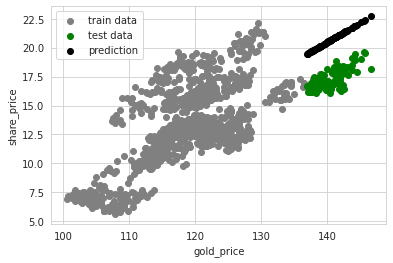

AU
Coefficients:  0.31252669952857776
[[1.         0.67830589]
 [0.67830589 1.        ]]
Mean Absolute Error: 2.2471377544809683
Mean Squared Error: 5.789211153877581
Root Mean Squared Error: 2.4060779608893768


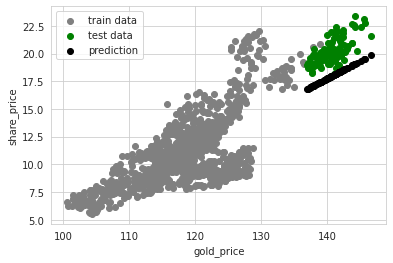

KGC
Coefficients:  0.10461302060876282
[[1.         0.78266367]
 [0.78266367 1.        ]]
Mean Absolute Error: 1.0583009847297946
Mean Squared Error: 1.1523726951635975
Root Mean Squared Error: 1.073486234268329


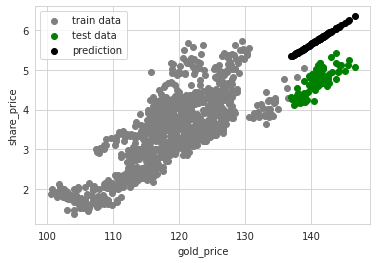

NCM.AX
Coefficients:  0.5623005799590818
[[1.         0.79891272]
 [0.79891272 1.        ]]
Mean Absolute Error: 2.0335289996635937
Mean Squared Error: 5.836462091267656
Root Mean Squared Error: 2.415877085297937


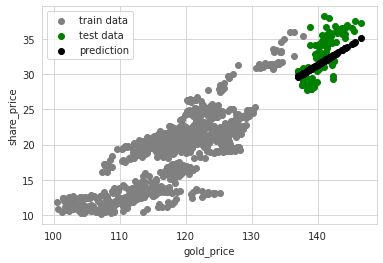

PLZL.ME
Coefficients:  103.84435014609612
[[1.         0.60373084]
 [0.60373084 1.        ]]
Mean Absolute Error: 1315.093426667142
Mean Squared Error: 1776892.2964767825
Root Mean Squared Error: 1333.0012364873419


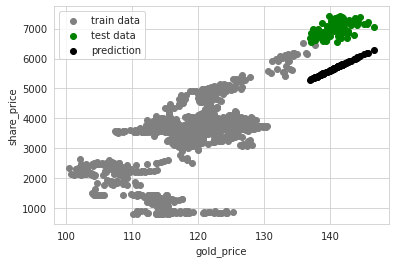

POLY.ME
Coefficients:  10.772023429299809
[[1.         0.63694034]
 [0.63694034 1.        ]]
Mean Absolute Error: 69.33753863275061
Mean Squared Error: 6800.525447108329
Root Mean Squared Error: 82.46529844187995


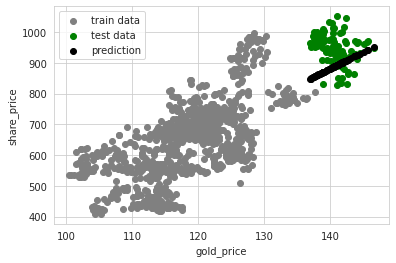

SELG.ME
Coefficients:  0.15570348678870732
[[1.         0.51630147]
 [0.51630147 1.        ]]
Mean Absolute Error: 1.8096071903165585
Mean Squared Error: 4.039450515732427
Root Mean Squared Error: 2.009838430255633


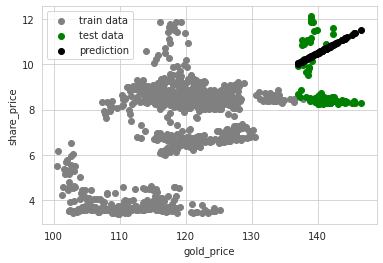

In [66]:
for sh in shares:
  print(sh)
  #Data Preparation
  share_18=pd.DataFrame()
  share_18=all_data_15[(all_data_15['name']==sh)] # Get data 2018/19
  share_18=share_18[["share_price","gold_price"]].reset_index()
  # Just using 1 variable for linear regression. Split the data into training/testing sets
  train = share_18[:-100]
  test = share_18[-100:]

  x_train=train["gold_price"].to_frame() 
  y_train=train['share_price'].to_frame()
  x_test=test["gold_price"].to_frame() 
  y_test=test['share_price'].to_frame()

  
  regr = LinearRegression() #Create linear regression object

    
  regr.fit(x_train,y_train) #Train the model using the training sets

  print("Coefficients: ",  float(regr.coef_))
  print(np.corrcoef(x_train,y_train, rowvar=False))

  y_pred = regr.predict(x_test)
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  
  # Plot outputs using matplotlib
  plt_train=plt.scatter(x_train["gold_price"],y_train,   color='grey')
  plt_test=plt.scatter(x_test["gold_price"],y_test,   color='green')
  plt_pred=plt.scatter(x_test["gold_price"], y_pred,  color='black')

  plt.xlabel("gold_price")
  plt.ylabel("share_price")
  plt.legend((plt_train, plt_test,plt_pred),("train data", "test data","prediction"))
  plt.show()


From the above charts, we can conclude that the price of gold predicts the price of shares of foreign companies on the next day quite well. In Russian companies, this picture looks much worse. Of course, there may be a false impression about Seligdar shares. But visual analysis of the chart allows you to discard this assumption.

### 3.3 Random forest on Newmont Goldcorp shares against the price of gold and shares of gold companies

Random forest is a machine learning algorithm that uses a Committee (ensemble) of decision trees. The main idea is to use a large ensemble of decision trees, each of which in itself gives a very low quality of classification, but due to their large number, the result is good.

The random forest algorithm accepts more than one variable in the input data to predict the output data. It works very efficiently on large amounts of data, can handle many input variables, has efficient methods for estimating missing data, and many other advantages. The main disadvantages are:
1. Random forests is slow to generate forecasts because it has many decision trees. Whenever it makes a forecast, all the trees in the forest must make a forecast for the same given input and then vote on it. This whole process takes a long time.
2. the Model is difficult to interpret compared to the decision tree, where you can easily make a decision by following the path in the tree.

One of the great advantages of a random forest is that it can be used for both classification and regression problems, which make up most of today's machine learning systems. I will talk about random forests in classification, since classification is sometimes considered a building block of machine learning. Below you can see what a random forest with two trees looks like:

In addition to the gold price, we will use other variables to forecast the Newmont Goldcorp share price. This will be the share prices of other foreign gold mining companies. I know it doesn't make a lot of sense, but we just want to see how to build this type of model. This will allow us to see the impact of each of them on the final forecast.Random forest is a machine learning algorithm that uses a Committee (ensemble) of decision trees. The main idea is to use a large ensemble of decision trees, each of which in itself gives a very low quality of classification, but due to their large number, the result is good.


In [67]:
from sklearn.ensemble import RandomForestRegressor
# 1.- Data Preparation
nmm15=pd.DataFrame()
nmm15=all_data_15[(all_data_15['name']=="NMM.SG") & (all_data_15['year']>2016 )]
nmm15=nmm15[["share_price","gold_price"]].reset_index()

# Load share price of other variables
nmm15['GOLD']=all_data_15[(all_data_15['name']=="GOLD")][-980:].reset_index()['share_price']
nmm15['GOLD'] = nmm15['GOLD'].shift(1)
nmm15['AU']=all_data_15[(all_data_15['name']=="AU")][-980:].reset_index()['share_price']
nmm15['AU'] = nmm15['AU'].shift(1)
nmm15['KGC']=all_data_15[(all_data_15['name']=="KGC")][-980:].reset_index()['share_price']
nmm15['KGC'] = nmm15['KGC'].shift(1)
nmm15['NCM.AX']=all_data_15[(all_data_15['name']=="NCM.AX")][-980:].reset_index()['share_price']
nmm15['NCM.AX'] = nmm15['NCM.AX'].shift(1)

nmm15 = nmm15.drop(nmm15.index[0])

train = nmm15[:-100]
test = nmm15[-100:]

x_train=train[["gold_price","GOLD","AU","KGC","NCM.AX"]]
y_train=train['share_price']

x_test=test[["gold_price","GOLD","AU","KGC","NCM.AX",]] 
y_test=test['share_price'].to_frame()


# 2.- Create Randomforest object usinig a max depth=5
regressor = RandomForestRegressor(n_estimators=200, max_depth=5 )

# 3.- Train data
clf=regressor.fit(x_train, y_train)

# 4.- Predict!
y_pred=regressor.predict(x_test)
y_pred_list = list(y_pred)
y_pred=pd.DataFrame(y_pred)

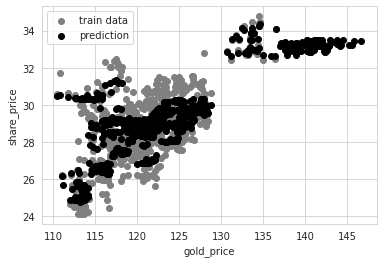

In [68]:
# We are going to have a look at how fitted data looks like:

plt_train=plt.scatter(x_train["gold_price"],y_train,   color='grey')
plt_pred=plt.scatter(nmm15["gold_price"], regressor.predict(nmm15[["gold_price","GOLD","AU","KGC","NCM.AX"]]),  color='black')

plt.xlabel("gold_price")
plt.ylabel("share_price")
plt.legend((plt_train,plt_pred),("train data","prediction"))
plt.show()

The resulting model looks really good in addition, we must remember that Random Forest has many more parameters to configure, but the key one is the maximum depth, which is unlimited by default. Next, we'll check how this model predicts or tests data.

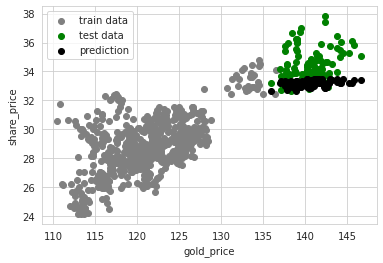

In [69]:
plt_train=plt.scatter(x_train["gold_price"],y_train,   color='grey')
plt_test=plt.scatter(x_test["gold_price"],y_test,   color='green')
plt_pred=plt.scatter(x_test["gold_price"], y_pred,  color='black')

plt.xlabel("gold_price")
plt.ylabel("share_price")
plt.legend((plt_train, plt_test,plt_pred),("train data", "test data","prediction"))
plt.show()

In [70]:
  # Get error
  y_pred = clf.predict(x_test)
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.410409517520304
Mean Squared Error: 3.0995744019029483
Root Mean Squared Error: 1.7605608202794212


Feature ranking:
Feature gold_price (0.627703)
Feature GOLD (0.045197)
Feature AU (0.040957)
Feature KGC (0.038973)
Feature NCM.AX (0.247171)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Importance')

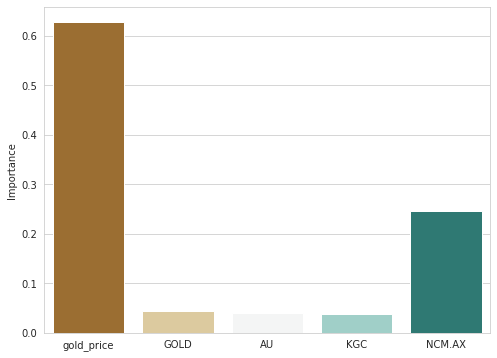

In [71]:
importances=regressor.feature_importances_

indices=list(x_train)
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("Feature %s (%f)" % (indices[f], importances[f]))

f, (ax1) = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
sns.barplot(indices, importances, palette="BrBG", ax=ax1)
ax1.set_ylabel("Importance")

By the importance of the signs, it immediately becomes clear how strong the value of gold is.

In short, I hope I was able to reveal to you the beginnings of a project on using machine learning to study stock prices, and I hope to hear your comments.